In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
train_dataset = MNIST(True)
test_dataset = MNIST(False)

In [4]:
train_x, train_y = train_dataset.data.numpy(), train_dataset.targets
test_x, test_y = test_dataset.data.numpy(), test_dataset.targets
train_y2 = to_one_hot(train_y, 10).numpy()
test_y2 = to_one_hot(test_y, 10).numpy()
train_y = train_y.numpy()
test_y = test_y.numpy()

In [5]:
train_data = FromNumpy(train_x[:, None, :, :], [train_y2, train_y], batch_size=256)
test_data = FromNumpy(test_x[:, None, :, :], [test_y2, test_y], batch_size=256)

In [6]:
class Auxiliary(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        self.store = None
    
    def forward(self, x):
        # Store the result
        # Return the origin value
        self.store = self.f(x)
        return x 

In [7]:
class Reg(nn.Module):
    def __init__(self, f, group, get='weight'):
        super().__init__()
        self.f = f
        self.get = get
        self.reg_store = None
        self.reg_group = group
        
    def forward(self, x):
        out = self.f(x)
        if self.get == 'weight':
            self.reg_store = self.f.weight
        elif self.get == 'out':
            self.reg_store = out
        elif self.get == 'in':
            self.reg_stroe = x
        return out
    

In [8]:
class Orthogonal(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, w1, w2):
        return self.alpha * torch.matmul(w1, w2.t()).abs().mean()

In [9]:
model = builder([
    nn.Conv2d(1, 20, 5, 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(20, 50, 5, 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    Flatten(),
    Auxiliary(builder([
        Reg(nn.Linear(4*4*50, 128), 'orth'),
        nn.ReLU(),
        Reg(nn.Linear(128, 10), 'orth2'),
        nn.Sigmoid()
    ])),
    Reg(nn.Linear(4*4*50, 128), 'orth'),
    nn.ReLU(),
    Reg(nn.Linear(128, 10), 'orth2'),
    nn.Softmax(1)
])

In [23]:
runner = Runner(model, train_data, test_data, 'adam', ['bce', 'll'], reg_fn={'orth': Orthogonal(), 'orth2': Orthogonal()})

In [24]:
runner.fit(10, cycle='cycle')

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*        0.0176        0.9951        0.0536        0.9907    


    2*        0.0188        0.9949        0.0478        0.9893    


    3         0.0045        0.9987        0.0419        0.9910    


    4         0.0028        0.9993        0.0484        0.9898    


    5         0.0012        0.9997        0.0465        0.9911    


    6         0.0002        1.0000        0.0464        0.9910    


    7         0.0002        1.0000        0.0473        0.9911    


    8         0.0001        1.0000        0.0476        0.9912    


    9         0.0001        1.0000        0.0479        0.9912    


    10        0.0001        1.0000        0.0481        0.9912    


    11        0.0001        1.0000        0.0488        0.9910    


    12        0.0001        1.0000        0.0492        0.9913    


    13        0.0001        1.0000        0.0493        0.9913    


    14        0.0000        1.0000        0.0526        0.9912    


    15        0.0000        1.0000        0.0495        0.9912    


    16        0.0001        1.0000        0.0529        0.9912    


    17        0.0000        1.0000        0.0500        0.9912    


KeyboardInterrupt: 

In [25]:
model = runner.model

tensor(5.)
tensor([[3.5814e-20, 5.7431e-23, 1.5912e-22, 4.8028e-20, 1.4820e-25, 1.0000e+00,
         1.5952e-18, 9.4211e-19, 1.0235e-19, 4.4684e-14]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[4.3504e-24, 2.9636e-21, 8.2545e-22, 9.6002e-17, 1.6874e-19, 1.0000e+00,
         1.9140e-19, 1.6440e-18, 2.8291e-14, 4.4237e-14]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[1.5554e-43, 1.6956e-43, 1.3172e-43, 4.6108e-36, 2.5223e-44, 1.0000e+00,
         3.0532e-37, 1.5488e-36, 2.8955e-33, 1.9767e-27]], device='cuda:0',
       grad_fn=<MulBackward0>)


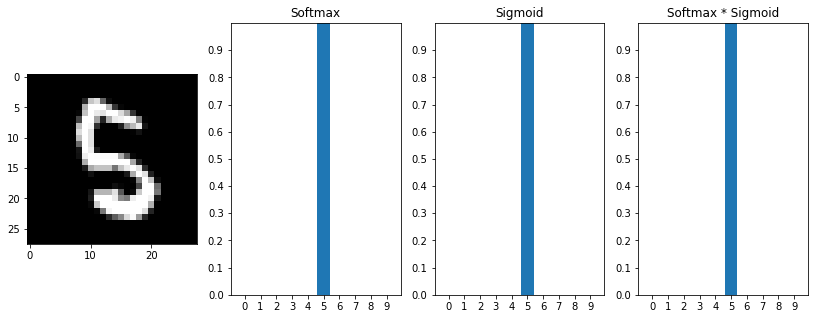

In [58]:
data = next(iter(test_data))
x = data[0][0]
x = x[None, :, :, :]
print(data[2][0])
#x = torch.rand_like(x)*500 + x
#x = x.permute(0,1,3,2)
out1 = model(x.cuda())
out2 = get_aux_out(model)[0]
print(out1)
print(out2)
print((out1*out2))

import matplotlib.pyplot as plt
fig, arr = plt.subplots(1, 4, figsize=(14, 5))
arr[0].imshow(x.numpy()[0][0], cmap='gray')
arr[1].set_title('Softmax')
arr[1].set_xticks(range(10))
arr[1].set_yticks([i/10 for i in range(10)])
arr[1].set_ylim(0, 1)
arr[1].bar(range(10), out1.detach().cpu().numpy()[0])
arr[2].set_title('Sigmoid')
arr[2].set_xticks(range(10))
arr[2].set_yticks([i/10 for i in range(10)])
arr[2].set_ylim(0, 1)
arr[2].bar(range(10), out2.detach().cpu().numpy()[0])
arr[3].set_title('Softmax * Sigmoid')
arr[3].set_xticks(range(10))
arr[3].set_yticks([i/10 for i in range(10)])
arr[3].set_ylim(0, 1)
arr[3].bar(range(10), ((out1*out2)).detach().cpu().numpy()[0])
plt.show()
